In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

handshake_df = pd.read_csv("./handshake.csv")
display(
    handshake_df.groupby(["kex", "auth"]).size(
    ).reset_index(name="count").sort_values(["kex", "auth"])
)

,kex,auth,count
0,hqc128,mldsa44-mldsa44-hqc128,3007
1,hqc128,mldsa44-mldsa44-mldsa44,3166
2,hqc128,sphincs128f-mldsa44-mldsa44,3105
3,mlkem512,falcon512-falcon512-falcon512,4352
4,mlkem512,falcon512-mldsa44-mldsa44,3049
5,mlkem512,mldsa44-mldsa44-mldsa44,3191
6,mlkem512,mldsa44-mldsa44-mlkem512,3279
7,mlkem512,sphincs128f-mldsa44-mldsa44,3317
8,mlkem512,sphincs128s-mldsa44-mldsa44,3905
9,ot-mlkem512,mldsa44-mldsa44-mldsa44,4401


In [2]:
def plot_multiple_histograms(data_dict, bins=10, alpha=0.6, title=None, 
                             density=True, save=None, figsize=(15, 6)):
    """
    Plots multiple histograms on the same figure for each label in the input dictionary.

    Parameters:
        data_dict (dict): A dictionary where keys are labels (str) and values are lists of integers.
        bins (int): Number of bins to use in the histograms.
        alpha (float): Transparency level for the histograms (0.0 to 1.0).
        title (str): Title of the plot.
    """
    plt.figure(figsize=figsize)

    for label, values in data_dict.items():
        weights = (np.ones_like(values) / len(values)) * 100
        plt.hist(values, bins=bins, alpha=alpha, label=label, weights=weights)

    plt.title(title)
    plt.xlabel("Duration (microseconds)")
    plt.ylabel("Percentage" if density else "Count")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if save:
        plt.savefig(save, dpi=300, bbox_inches='tight')
    plt.show()


kex Key exchange time            Key exchange CPU time        
                          median        std                median     std
0       hqc128         1341054.5  303532.68             1321492.0   80.01
1     mlkem512           25900.0  226552.13               19526.0  105.89
2  ot-mlkem512           16938.0    5573.21               14025.0   41.26
3    secp256r1          445096.0  195745.12              438639.0  182.35
4       x25519           36322.5  713456.00               28813.0   31.68

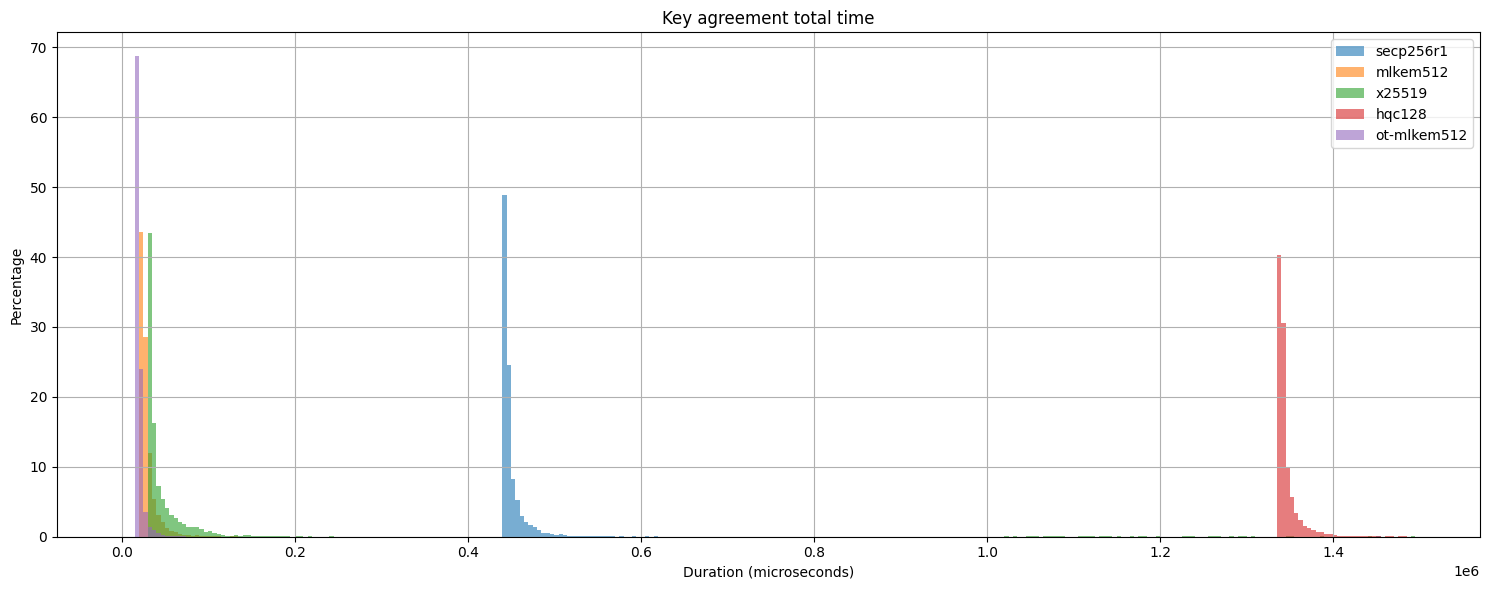

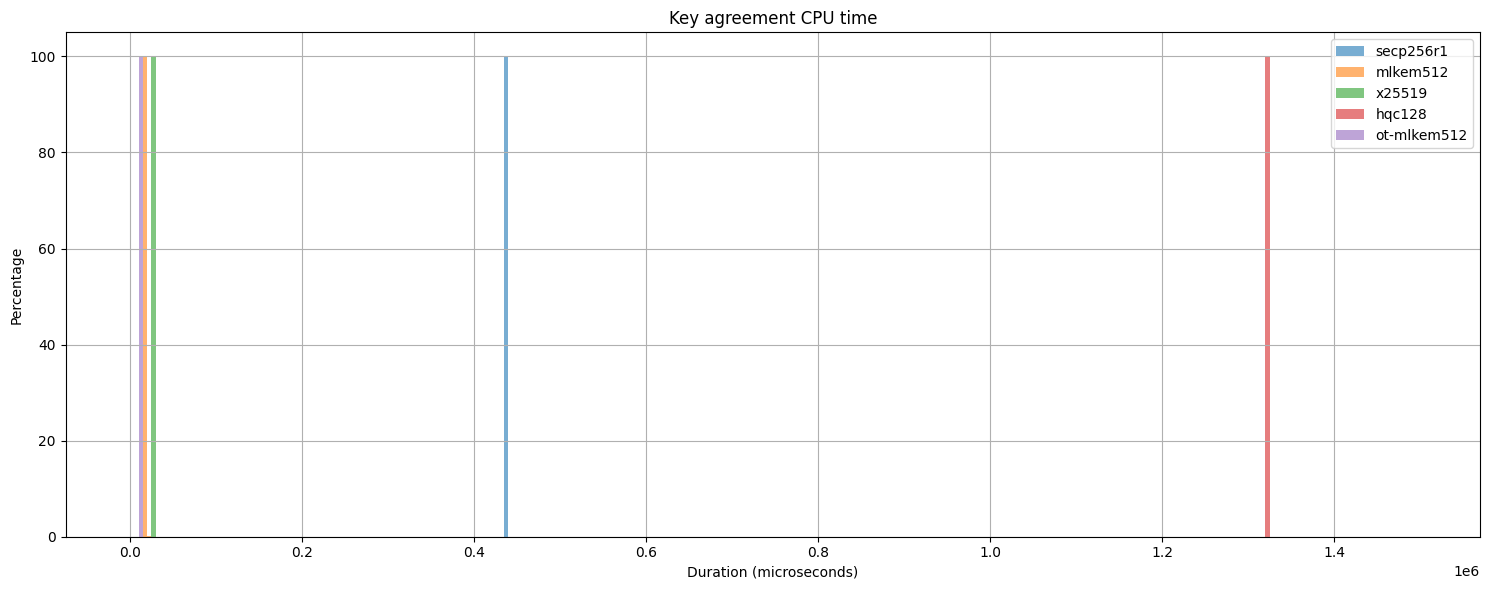

In [3]:
"""Key agreement performance: there are two important durations to keep track of
total duration is the time from handshake start to exiting DoTls13ServerHello
CPU duration is the time during which the CPU is doing crypto work, so it is the
total duration minus the time between "ClientHello sent" and "ServerHello done"
"""

durs_df = handshake_df[
    ["kex", "auth", "ch_start", "ch_sent", "sh_start", "sh_done",
     "auth_start", "auth_done"]].copy()
durs_df["ka_tot_dur"] = durs_df["sh_done"] - durs_df["ch_start"]
durs_df["ka_cpu_dur"] = (
    durs_df["ch_sent"] - durs_df["ch_start"] 
    + durs_df["sh_done"] - durs_df["sh_start"]
)
durs_df["cert_tx_dur"] = durs_df["auth_start"] - durs_df["sh_done"]
durs_df["auth_dur"] = durs_df["auth_done"] - durs_df["auth_start"]
durs_df["handshake_dur"] = durs_df["auth_done"] - durs_df["ch_start"]
durs_df["handshake_suite"] = durs_df["kex"] + "," + durs_df["auth"]
assert (
    (durs_df["ka_tot_dur"] > 0).all() 
    and (durs_df["ka_cpu_dur"] > 0).all()
    and (durs_df["cert_tx_dur"] > 0).all()
    and (durs_df["auth_dur"] > 0).all()
    and (durs_df["handshake_dur"] > 0).all()
)

summary = durs_df.groupby(["kex"]).agg({
    "ka_tot_dur": ["median", "std"],
    "ka_cpu_dur": ["median", "std"],
}).round(2).rename(
    columns={
        "ka_tot_dur": "Key exchange time", 
        "ka_cpu_dur": "Key exchange CPU time",
    }
).reset_index()
display(summary)

plot_multiple_histograms(
    {
        kex: durs_df.loc[durs_df["kex"] == kex, "ka_tot_dur"]
        for kex in durs_df["kex"].unique()
    },
    bins=list(range(0, 1_500_000, 5_000)),
    title="Key agreement total time",
    save="imgs/ka_tot_dur.png",
)

plot_multiple_histograms(
    {
        kex: durs_df.loc[durs_df["kex"] == kex, "ka_cpu_dur"]
        for kex in durs_df["kex"].unique()
    },
    bins=list(range(0, 1_500_000, 5_000)),
    title="Key agreement CPU time",
    save="imgs/ka_cpu_dur.png",
)

auth Certificate transmission time  \
                                                              median   
0              ed25519-ed25519-ed25519                      202659.0   
1        falcon512-falcon512-falcon512                       20340.0   
2            falcon512-mldsa44-mldsa44                       23245.0   
3               mldsa44-mldsa44-hqc128                       31988.0   
4              mldsa44-mldsa44-mldsa44                       24872.0   
5             mldsa44-mldsa44-mlkem512                       23639.0   
6              rsa2048-rsa2048-rsa2048                       18017.0   
7  sha256ecdsa-sha256ecdsa-sha256ecdsa                       23953.5   
8          sphincs128f-mldsa44-mldsa44                       69397.5   
9          sphincs128s-mldsa44-mldsa44                       37403.0   

             Authentication time           Handshake time             
         std              median       std         median        std  
0  245247.57             80999.5    177.74       325062.5  770088.22  
1    3624.14             58079.0  58265.61       102108.0  131869.23  
2    4159.28            102627.0  19974.49       152006.0  122511.39  
3    1475.30            818930.0  95402.16      2191660.0  118635.75  
4   41613.12            120079.0  89610.66       168402.5  703292.18  
5    8218.17            142525.0  95978.65       191691.0  132568.78  
6   63425.70             83073.0   3658.47       551049.0   65015.36  
7  113086.63            457164.5   1474.15       933640.5  298411.88  
8  203525.98           1239345.5   1785.34      1676532.0  662554.97  
9  131333.25            472174.0   1451.93       537365.0  259538.50

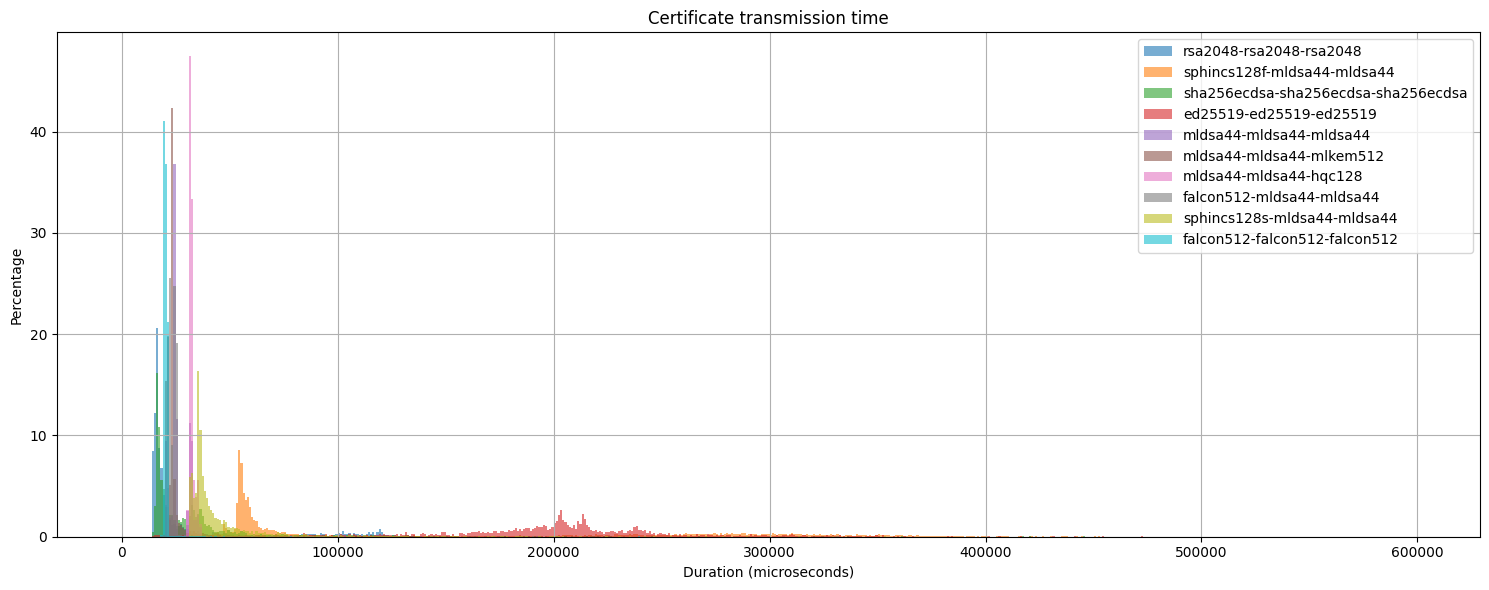

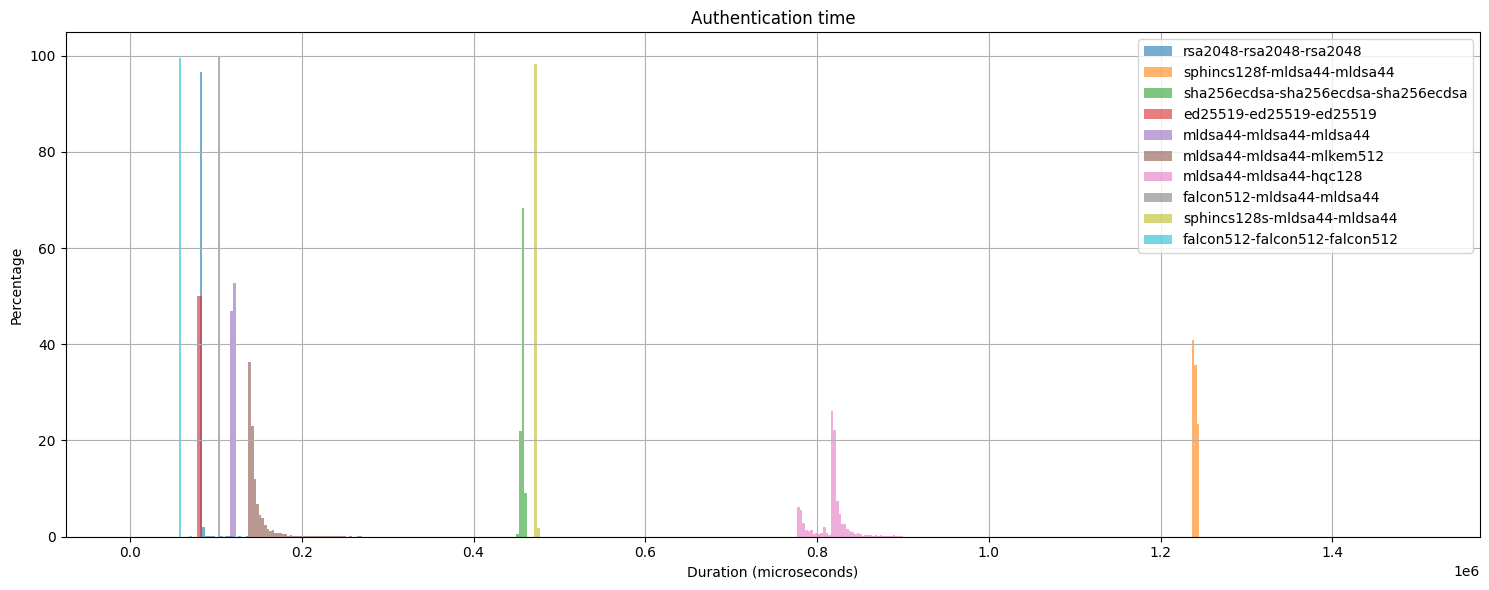

In [4]:
# Authentication
summary = durs_df.groupby(["auth"]).agg({
    "cert_tx_dur": ["median", "std"],
    "auth_dur": ["median", "std"],
    "handshake_dur": ["median", "std"],
}).round(2).rename(
    columns={
        "cert_tx_dur": "Certificate transmission time",
        "auth_dur": "Authentication time",
        "handshake_dur": "Handshake time",
    }
).reset_index()
display(summary)

plot_multiple_histograms(
    {
        auth: durs_df.loc[durs_df["auth"] == auth, "cert_tx_dur"]
        for auth in durs_df["auth"].unique()
    },
    # {
    #     "ED25519": durs_df.loc[durs_df["auth"] == "ed25519-ed25519-ed25519", "cert_tx_dur"],
    #     "ECDSA (P256)": durs_df.loc[durs_df["auth"] == "sha256ecdsa-sha256ecdsa-sha256ecdsa", "cert_tx_dur"],
    #     "RSA2048": durs_df.loc[durs_df["auth"] == "rsa2048-rsa2048-rsa2048", "cert_tx_dur"],
    # },
    bins=list(range(0, 600_000, 1_000)),
    title="Certificate transmission time",
    save="imgs/cert_tx_time.png"
)

plot_multiple_histograms(
    {
        auth: durs_df.loc[durs_df["auth"] == auth, "auth_dur"]
        for auth in durs_df["auth"].unique()
    },
    bins=list(range(0, 1_500_000, 3_000)),
    title="Authentication time",
    save="imgs/auth_time.png"
)

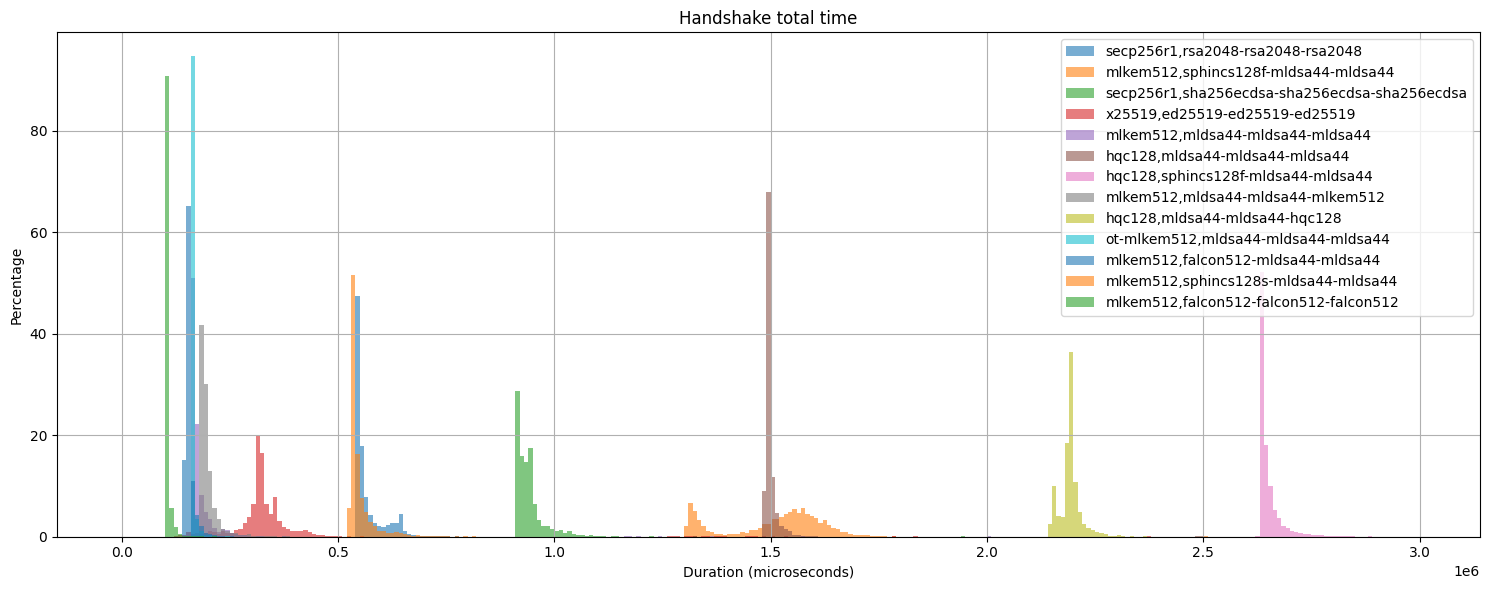

In [5]:
plot_multiple_histograms(
    {
        suite: durs_df.loc[durs_df["handshake_suite"] == suite, "handshake_dur"] 
        for suite in durs_df["handshake_suite"].unique()
    },
    bins=list(range(0, 3_000_000, 10_000)),
    title="Handshake total time",
    save="imgs/handshake_time.png"
)